In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


# Download data from kaggle

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download raddar/tuberculosis-chest-xrays-shenzhen

In [ ]:
!unzip "/content/tuberculosis-chest-xrays-shenzhen.zip" -d "/content/gdrive/MyDrive/Year3/Indiv/"

# Import

In [2]:
import copy
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
from numpy import savetxt
%matplotlib inline
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay # metrics error
from sklearn.model_selection import train_test_split # resampling method
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, AdaptiveAvgPool2d, Flatten
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision import *

In [3]:
def format_cuda_version(version):
    return 'cu' + version.replace('.', '')
CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Create dataframe

In [ ]:
# creating a data frame
df = pd.read_csv("/content/gdrive/MyDrive/Year3/Indiv/shenzhen_metadata.csv")
print(df.head())
print(df.tail())

            study_id     sex  age findings
0  CHNCXR_0001_0.png    Male   45   normal
1  CHNCXR_0002_0.png    Male   63   normal
2  CHNCXR_0003_0.png  Female   48   normal
3  CHNCXR_0004_0.png    Male   58   normal
4  CHNCXR_0005_0.png    Male   28   normal
              study_id  ...                                           findings
657  CHNCXR_0658_1.png  ...   bilateral secondary PTB  with right pneumothorax
658  CHNCXR_0659_1.png  ...             secondary PTB  in the left upper field
659  CHNCXR_0660_1.png  ...  1.bilateral secondary PTB  with right upper at...
660  CHNCXR_0661_1.png  ...  bilateral secondary PTB  with right pleural th...
661  CHNCXR_0662_1.png  ...            secondary PTB  in the right upper field

[5 rows x 4 columns]


In [ ]:
row = len(df)
column = len(df.columns)

In [ ]:
df['study_id'][0]

'CHNCXR_0001_0.png'

In [ ]:
ex = cv2.imread("/content/gdrive/MyDrive/Year3/Indiv/images/images/"+df['study_id'][200],0)
ex1 = ex.shape[0]
ex2 = ex.shape[1]

In [ ]:
ex1

1583

In [ ]:
# add image to dataframe
image = np.ndarray(shape=(row,224,224),dtype=np.uint8)
for i in range(row):
  a = cv2.imread("/content/gdrive/MyDrive/Year3/Indiv/images/images/"+df['study_id'][i],0) # each image has different size
  print(df['study_id'][i],a.shape)
  are = cv2.resize(a, (224,224), interpolation = cv2.INTER_AREA) # reshape all image to (224,224)
  #a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  filename = "/content/gdrive/MyDrive/Year3/Indiv/images/images_224/"+df['study_id'][i]+"_224"
  cv2.imwrite(filename, are)
  image[i,:,:]=are
#df['image']=image

CHNCXR_0001_0.png (2919, 3000)
CHNCXR_0002_0.png (2951, 3000)
CHNCXR_0003_0.png (2945, 2987)
CHNCXR_0004_0.png (2933, 3000)
CHNCXR_0005_0.png (2933, 3000)
CHNCXR_0006_0.png (2948, 2775)
CHNCXR_0007_0.png (2320, 2306)
CHNCXR_0008_0.png (2937, 3000)
CHNCXR_0009_0.png (2942, 2516)
CHNCXR_0010_0.png (2947, 3000)
CHNCXR_0011_0.png (2921, 3000)
CHNCXR_0012_0.png (2959, 3000)
CHNCXR_0013_0.png (2937, 3000)
CHNCXR_0014_0.png (2919, 3000)
CHNCXR_0015_0.png (2941, 3000)
CHNCXR_0016_0.png (2943, 3000)
CHNCXR_0017_0.png (2908, 2789)
CHNCXR_0018_0.png (2907, 2991)
CHNCXR_0019_0.png (2941, 3000)
CHNCXR_0020_0.png (2555, 2760)
CHNCXR_0021_0.png (2953, 2868)
CHNCXR_0022_0.png (2951, 3000)
CHNCXR_0023_0.png (2937, 3000)
CHNCXR_0024_0.png (2951, 3000)
CHNCXR_0025_0.png (2937, 3000)
CHNCXR_0026_0.png (2933, 3000)
CHNCXR_0027_0.png (2925, 2997)
CHNCXR_0028_0.png (2941, 3000)
CHNCXR_0029_0.png (2935, 3000)
CHNCXR_0030_0.png (2461, 2357)
CHNCXR_0031_0.png (2939, 2989)
CHNCXR_0032_0.png (2927, 3000)
CHNCXR_0

In [ ]:
# add image to dataframe
image = np.ndarray(shape=(row,256,256),dtype=np.uint8)
for i in range(row):
  a = cv2.imread("/content/gdrive/MyDrive/Year3/Indiv/images/images/"+df['study_id'][i],0) # each image has different size
  print(df['study_id'][i],a.shape)
  are = cv2.resize(a, (256,256), interpolation = cv2.INTER_AREA) # reshape all image to (256,256)
  #a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  filename = "/content/gdrive/MyDrive/Year3/Indiv/images/images_256/"+df['study_id'][i]+"_256"
  cv2.imwrite(filename, are)
  image[i,:,:]=are
#df['image']=image

CHNCXR_0001_0.png (2919, 3000)
CHNCXR_0002_0.png (2951, 3000)
CHNCXR_0003_0.png (2945, 2987)
CHNCXR_0004_0.png (2933, 3000)
CHNCXR_0005_0.png (2933, 3000)
CHNCXR_0006_0.png (2948, 2775)
CHNCXR_0007_0.png (2320, 2306)
CHNCXR_0008_0.png (2937, 3000)
CHNCXR_0009_0.png (2942, 2516)
CHNCXR_0010_0.png (2947, 3000)
CHNCXR_0011_0.png (2921, 3000)
CHNCXR_0012_0.png (2959, 3000)
CHNCXR_0013_0.png (2937, 3000)
CHNCXR_0014_0.png (2919, 3000)
CHNCXR_0015_0.png (2941, 3000)
CHNCXR_0016_0.png (2943, 3000)
CHNCXR_0017_0.png (2908, 2789)
CHNCXR_0018_0.png (2907, 2991)
CHNCXR_0019_0.png (2941, 3000)
CHNCXR_0020_0.png (2555, 2760)
CHNCXR_0021_0.png (2953, 2868)
CHNCXR_0022_0.png (2951, 3000)
CHNCXR_0023_0.png (2937, 3000)
CHNCXR_0024_0.png (2951, 3000)
CHNCXR_0025_0.png (2937, 3000)
CHNCXR_0026_0.png (2933, 3000)
CHNCXR_0027_0.png (2925, 2997)
CHNCXR_0028_0.png (2941, 3000)
CHNCXR_0029_0.png (2935, 3000)
CHNCXR_0030_0.png (2461, 2357)
CHNCXR_0031_0.png (2939, 2989)
CHNCXR_0032_0.png (2927, 3000)
CHNCXR_0

In [ ]:
image.shape

(662, 256, 256)

In [ ]:
#with open('/content/gdrive/MyDrive/Year3/Indiv/img_data.csv', 'w') as outfile:
    #for slice_2d in image:
        #np.savetxt(outfile, slice_2d)

In [ ]:
label = []
for i in range(row):
  if (df['findings'][i]=='normal'):
    label.append(0) # 0:normal
  else:
    label.append(1) # 1:abnormal

In [ ]:
df['label'] = label

In [ ]:
df.head()

,study_id,sex,age,findings,label
0,CHNCXR_0001_0.png,Male,45,normal,0
1,CHNCXR_0002_0.png,Male,63,normal,0
2,CHNCXR_0003_0.png,Female,48,normal,0
3,CHNCXR_0004_0.png,Male,58,normal,0
4,CHNCXR_0005_0.png,Male,28,normal,0


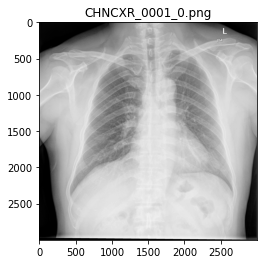

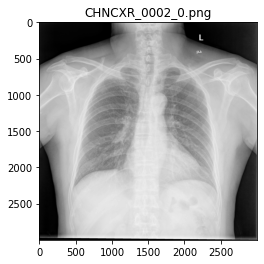

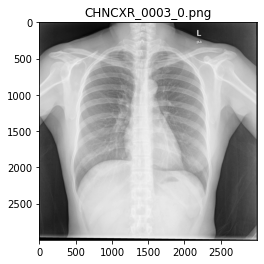

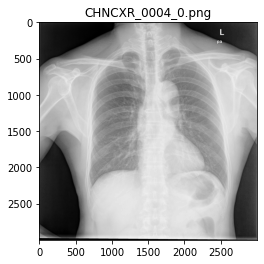

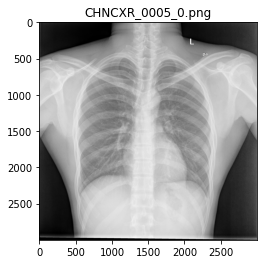

In [ ]:
for i in range(5):
  plt.imshow(image[i], cmap='gray')
  plt.title(df['study_id'][i])
  plt.show()

In [ ]:
(df['findings']=='normal').value_counts()
# normal: 326 people and not normal: 336 people

False    336
True     326
Name: findings, dtype: int64

In [ ]:
df.to_csv('/content/gdrive/MyDrive/Year3/Indiv/data.csv',index=False)

# Preprocessing data

In [4]:
df = pd.read_csv('/content/gdrive/MyDrive/Year3/Indiv/data.csv')
row = len(df)
column = len(df.columns)

In [ ]:
#df.head()

,study_id,sex,age,findings,label
0,CHNCXR_0001_0.png,Male,45,normal,0
1,CHNCXR_0002_0.png,Male,63,normal,0
2,CHNCXR_0003_0.png,Female,48,normal,0
3,CHNCXR_0004_0.png,Male,58,normal,0
4,CHNCXR_0005_0.png,Male,28,normal,0


## Size 256

In [5]:
size=256
image_256 = np.ndarray(shape=(row,size,size))
path = "/content/gdrive/MyDrive/Year3/Indiv/images/images_256/"
#image_256 = []
for i in range(row):
  #a = cv2.imread("/content/gdrive/MyDrive/Year3/Indiv/images/images_256/"+df['study_id'][i]+"_256",0) # each image has different size
  a = cv2.imread(os.path.join(path, df['study_id'][i]+"_256"),0)
  #print(df['study_id'][i],a.shape)
  #image_256.append(a.flatten())
  # Histrogram Equalization
  #a = cv2.equalizeHist(a)
  #print(a)
  image_256[i,:,:] = a
# Normalizing the pixel values
image_256 /= 255.0
# Converting the type of pixel to float 32
image_256 = image_256.astype('float32')
image_256-=np.mean(image_256)
image_256/=np.std(image_256)

In [6]:
X_256 = image_256.copy() # train with small size image
X_256 = X_256.reshape((row, 1, 256, 256))
y_256 = df['label'].values
#X_train_val, X_test, y_train_val, y_test = train_test_split(X_256, y_256, test_size=0.15, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X_256, y_256, test_size = 0.15, random_state=2)
#X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.15, random_state=2)

In [ ]:
((y_train==0).sum(),(y_train==1).sum())

(274, 288)

In [ ]:
((y_val==0).sum(),(y_val==1).sum())

(52, 48)

## Size 224

In [19]:
size=224
image_224 = np.ndarray(shape=(row,size,size))
path = "/content/gdrive/MyDrive/Year3/Indiv/images/images_224/"
for i in range(row):
  #a = cv2.imread("/content/gdrive/MyDrive/Year3/Indiv/images/images_224/"+df['study_id'][i]+"_224",0) # each image has different size
  a = cv2.imread(os.path.join(path, df['study_id'][i]+"_224"),0)
  #print(df['study_id'][i],a.shape)
  #a = cv2.equalizeHist(a)
  image_224[i,:,:]=a
# normalizing the pixel values
image_224 /= 255.0
# converting the type of pixel to double
image_224 = image_224.astype('float32')
image_224-=np.mean(image_224)
image_224/=np.std(image_224)

In [35]:
X_224 = image_224.copy() # train with small size image
#X_224 = X_224.reshape((row, 3, 224, 224))
#X_224 = np.transpose(X_224,(0,3,1,2))
X_224 = X_224.reshape((row, 1, 224, 224))
y_224 = df['label'].values
X_train, X_val, y_train, y_val = train_test_split(X_224, y_224, test_size=0.15, random_state=2)

# Dataloader

In [7]:
class XrayDataSet(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [8]:
training_data = XrayDataSet(torch.tensor(X_train).to(device), torch.tensor(y_train).to(device))
validate_data = XrayDataSet(torch.tensor(X_val).to(device), torch.tensor(y_val).to(device))
#test_data = XrayDataSet(torch.tensor(X_test).to(device), torch.tensor(y_test).to(device))
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)
validate_dataloader = DataLoader(validate_data, batch_size=32)
#test_dataloader = DataLoader(test_data, batch_size=32)

In [9]:
X_train  = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train)
X_val  = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')


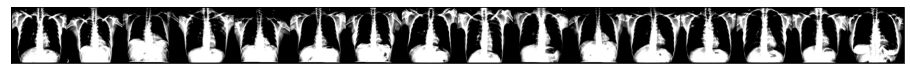

In [ ]:
def show_batch(dl):
   """Plot images grid of single batch"""
   for images, labels in dl:
       fig,ax = plt.subplots(figsize = (16,12))
       ax.set_xticks([])
       ax.set_yticks([])
       ax.imshow(make_grid(images.cpu(),nrow=16).permute(1,2,0))
       print(labels)
       break
show_batch(train_dataloader)

# Define Function

In [10]:
# For Model that using Dataloader
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()} #[val_loss, val_acc]
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    #print(outputs)
    _, preds = torch.max(outputs, dim=1)
    #print(preds)
    #print(labels)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))
  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func, min):
    history = []
    optimizer = opt_func(model.parameters(),lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.6, patience=1, min_lr=min)
    for epoch in range(epochs):  
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss.cpu().detach())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()      
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result) 
        print("Epoch "+str(epoch)+" : Done")
        scheduler.step(result['val_loss']) # schedule learning rate on validation loss
    return history

def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title("Validation accuracy")
    plt.show()

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training loss', 'Validation loss'])
    plt.title('Training loss and Validation loss');
    plt.show()

In [11]:
# For Model that does not using Dataloader
def train(model,epoch,x_train,y_train,x_val,y_val):
    model.train()
    tr_loss = 0
    # getting the training set
    # x_train, y_train = X_train, y_train
    # getting the validation set
    # x_val, y_val = X_val, y_val
    # converting the data into GPU format
    if torch.cuda.is_available():
       x_train = x_train.cuda()
       y_train = y_train.cuda()
       x_val = x_val.cuda()
       y_val = y_val.cuda()
    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)
    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train.cpu().detach().numpy())
    val_losses.append(loss_val.cpu().detach().numpy())
    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)
    scheduler.step(loss_val) # schedule learning rate on validation loss
  
def plot_result(train_losses,val_losses):
  plt.plot(train_losses, label='Training loss')
  plt.plot(val_losses, label='Validation loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('Training loss and Validation loss');
  plt.legend()
  plt.show()
  return

In [12]:
# For Pretrained model
def train2(n_epochs,train_dataloader,validate_dataloader,net,optimizer,criterion,min):
  print_every = 5
  valid_loss_min = np.Inf
  val_loss = []
  val_acc = []
  train_loss = []
  train_acc = []
  total_step = len(train_dataloader)
  scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.6, patience=1, min_lr=min)
  for epoch in range(1, n_epochs+1):
      running_loss = 0.0
      correct = 0
      total=0
      print(f'Epoch {epoch}\n')
      for batch_idx, (data_, target_) in enumerate(train_dataloader):
          data_, target_ = data_.to(device).float(), target_.to(device).long()
          optimizer.zero_grad()
          outputs = net(data_)
          loss = criterion(outputs, target_)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
          _,pred = torch.max(outputs, dim=1)
          correct += torch.sum(pred==target_).item()
          total += target_.size(0)
          if (batch_idx) % 20 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
      train_acc.append((100 * correct / total))
      train_loss.append((running_loss/total_step))
      print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
      batch_loss = 0
      total_t=0
      correct_t=0
      with torch.no_grad():
          net.eval()
          for data_t, target_t in (validate_dataloader):
              data_t, target_t = data_t.to(device), target_t.to(device)
              outputs_t = net(data_t)
              loss_t = criterion(outputs_t, target_t)
              batch_loss += loss_t.item()
              _,pred_t = torch.max(outputs_t, dim=1)
              correct_t += torch.sum(pred_t==target_t).item()
              total_t += target_t.size(0)
          val_acc.append((100 * correct_t/total_t))
          val_loss.append((batch_loss/len(validate_dataloader)))
          #network_learned = batch_loss < valid_loss_min
          network_learned = batch_loss <= valid_loss_min
          print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
          if network_learned:
              valid_loss_min = batch_loss
              torch.save(net.state_dict(), '/content/gdrive/MyDrive/Year3/Indiv/resnet.pt')
              print('Improvement-Detected, save-model')
      scheduler.step(batch_loss/len(validate_dataloader)) # schedule learning rate on validation loss
      net.train()
  return val_loss, val_acc, train_loss, train_acc

def visualize_model(net, num_images=4):
    images_so_far = 0
    #fig = plt.figure(figsize=(15, 10))
    for i, data in enumerate(validate_dataloader):
        inputs, labels = data
        if (device=='cuda'):
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if (device=='cuda') else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(validate_data.y[j])) # get label class
            imshow(inputs[j])
            if images_so_far == num_images:
                return 

def accuracy2(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

def imshow(inp, title=None):
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def plot_pre_accuracy(train_acc,val_acc):
  plt.title("Training accuracy and Validation accuracy")
  plt.plot(train_acc, label='Training')
  plt.plot(val_acc, label='Validation')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend(loc='best')
  plt.show()

def plot_pre_loss(train_losses,val_losses):
  plt.plot(train_loss, label='Training')
  plt.plot(val_loss, label='Validation')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(loc='best')
  plt.title('Training loss and Validation loss');
  plt.show()

# KNN

In [ ]:
def knn_classifier(X_re, y, t=0.25, distance=2, max_n=26):
  X_train, X_test, y_train, y_test = train_test_split(X_re, y, test_size=t, random_state=0)
  x_plot=[]
  y_plot=[]
  best_knn = None
  best_acc = -1
  best_k=0;
  for i in range(1,max_n): # find best k for knn
    knn = KNeighborsClassifier(n_neighbors=i,p=distance)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    print("n: "+str(i)+", Accuracy: "+str(metrics.accuracy_score(y_test, y_pred)))
    x_plot.append(i)
    y_plot.append(metrics.accuracy_score(y_test, y_pred))
    if(metrics.accuracy_score(y_test, y_pred)>best_acc):
      best_acc = metrics.accuracy_score(y_test, y_pred)
      best_knn = knn
      best_k = i
  plt.plot(x_plot, y_plot)
  plt.title("KNN classifier")
  plt.xlabel("k")
  plt.ylabel("Accuracy")
  plt.show()
  return best_knn, best_acc, best_k

In [ ]:
X_256 = image_256 # train with small size image
y_256 = df['label']

In [ ]:
X_re_256 =np.reshape(X_256,(row,size*size))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_re_256, y_256, test_size=0.2, random_state=0)

n: 1, Accuracy: 0.6807228915662651
n: 2, Accuracy: 0.7409638554216867
n: 3, Accuracy: 0.7710843373493976
n: 4, Accuracy: 0.7891566265060241
n: 5, Accuracy: 0.8012048192771084
n: 6, Accuracy: 0.8253012048192772
n: 7, Accuracy: 0.8012048192771084
n: 8, Accuracy: 0.7951807228915663
n: 9, Accuracy: 0.8192771084337349
n: 10, Accuracy: 0.8072289156626506
n: 11, Accuracy: 0.8012048192771084
n: 12, Accuracy: 0.8012048192771084
n: 13, Accuracy: 0.8012048192771084
n: 14, Accuracy: 0.7951807228915663
n: 15, Accuracy: 0.8012048192771084
n: 16, Accuracy: 0.8012048192771084
n: 17, Accuracy: 0.8072289156626506
n: 18, Accuracy: 0.8072289156626506
n: 19, Accuracy: 0.7951807228915663
n: 20, Accuracy: 0.8012048192771084
n: 21, Accuracy: 0.8012048192771084
n: 22, Accuracy: 0.8012048192771084
n: 23, Accuracy: 0.8012048192771084
n: 24, Accuracy: 0.8012048192771084
n: 25, Accuracy: 0.8012048192771084


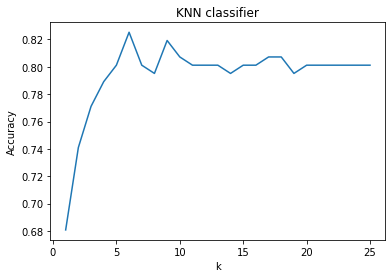

In [ ]:
best_knn, best_acc, best_k = knn_classifier(X_re_256, y_256) # minkowski_distance (l_p)

              precision    recall  f1-score   support

           0       0.76      0.95      0.85        61
           1       0.95      0.75      0.84        72

    accuracy                           0.84       133
   macro avg       0.86      0.85      0.84       133
weighted avg       0.86      0.84      0.84       133



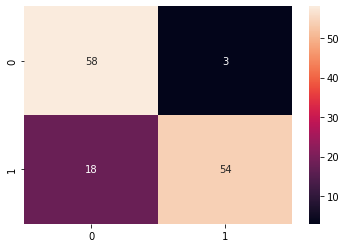

In [ ]:
# best k value = 6
y_pred = best_knn.predict(X_test)
print(metrics.classification_report(y_test, y_pred)) # has many false positive (predict normal instead of abnormal)
f = sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.show()

n: 1, Accuracy: 0.7469879518072289
n: 2, Accuracy: 0.7349397590361446
n: 3, Accuracy: 0.8072289156626506
n: 4, Accuracy: 0.7951807228915663
n: 5, Accuracy: 0.8072289156626506
n: 6, Accuracy: 0.8072289156626506
n: 7, Accuracy: 0.8313253012048193
n: 8, Accuracy: 0.8313253012048193
n: 9, Accuracy: 0.8313253012048193
n: 10, Accuracy: 0.8192771084337349
n: 11, Accuracy: 0.8253012048192772
n: 12, Accuracy: 0.8132530120481928
n: 13, Accuracy: 0.8072289156626506
n: 14, Accuracy: 0.8132530120481928
n: 15, Accuracy: 0.8132530120481928
n: 16, Accuracy: 0.8192771084337349
n: 17, Accuracy: 0.8132530120481928
n: 18, Accuracy: 0.8192771084337349
n: 19, Accuracy: 0.8132530120481928
n: 20, Accuracy: 0.8072289156626506
n: 21, Accuracy: 0.8012048192771084
n: 22, Accuracy: 0.8012048192771084
n: 23, Accuracy: 0.7951807228915663
n: 24, Accuracy: 0.8012048192771084
n: 25, Accuracy: 0.7951807228915663


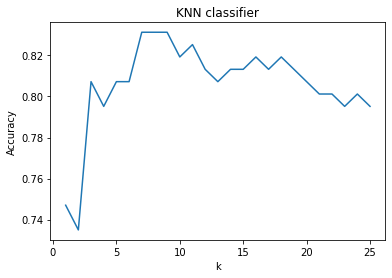

In [ ]:
best_knn_2, best_acc_2, best_k_2 = knn_classifier(X_re_256, y_256, distance=1) # manhattan_distance (l1), and euclidean_distance (l2)

              precision    recall  f1-score   support

           0       0.78      0.93      0.85        61
           1       0.93      0.78      0.85        72

    accuracy                           0.85       133
   macro avg       0.86      0.86      0.85       133
weighted avg       0.86      0.85      0.85       133



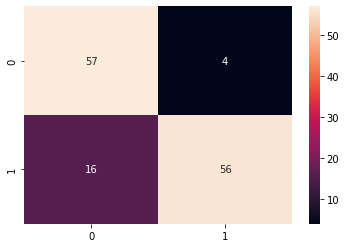

In [ ]:
# best k value = 7
y_pred_2 = best_knn_2.predict(X_test)
print(metrics.classification_report(y_test, y_pred_2)) # has many false positive (predict normal instead of abnormal)
f2 = sns.heatmap(metrics.confusion_matrix(y_test, y_pred_2), annot=True, fmt='d')
plt.show()

#CNN-1

## Training 1 -> Overfit

In [22]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )
        self.linear_layers = Sequential(
            Linear(16384, 2)
        )
    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [23]:
model_1 = Net()
optimizer = Adam(model_1.parameters(), lr=0.00004)
criterion = CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.85, patience=2, min_lr=0.0000001) # use scheduler to reduce learning rate
if torch.cuda.is_available():
    model_1 = model_1.cuda()
    criterion = criterion.cuda()
print(model_1)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=16384, out_features=2, bias=True)
  )
)


In [24]:
# Epoch 1-400
n_epochs = 400
train_losses = []
val_losses = []
for epoch in range(n_epochs):
    train(model_1,epoch,X_train,y_train,X_val,y_val)

Epoch :  1 	 loss : tensor(0.8976, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  3 	 loss : tensor(0.7746, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  5 	 loss : tensor(0.7105, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  7 	 loss : tensor(0.6650, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  9 	 loss : tensor(0.6207, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  11 	 loss : tensor(0.5720, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  13 	 loss : tensor(0.5386, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  15 	 loss : tensor(0.5149, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  17 	 loss : tensor(0.4968, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  19 	 loss : tensor(0.4847, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  21 	 loss : tensor(0.4739, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  23 	 loss : tensor(0.4647, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  25 	 loss : tensor(0.459

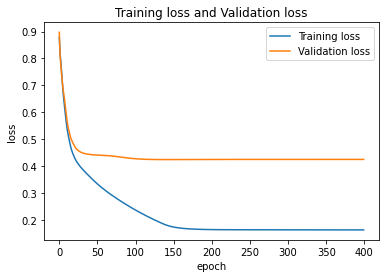

In [25]:
plot_result(train_losses,val_losses)

In [26]:
torch.save(model_1.state_dict(), '/content/gdrive/MyDrive/Year3/Indiv/CNN-1-1.pt')

In [27]:
model = Net().to(device)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/Year3/Indiv/CNN-1-1.pt'))

<All keys matched successfully>

In [28]:
# prediction for training set
with torch.no_grad():
  if (torch.cuda.is_available()):
    output = model(X_train.cuda())
  else:
    output = model(X_train)
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)
print("Training accuracy: "+str(accuracy_score(y_train, predictions)))

Training accuracy: 0.9608540925266904


In [29]:
# prediction for validation set
with torch.no_grad():
  if (torch.cuda.is_available()):
    output = model(X_val.cuda())
  else:
    output = model(X_val)
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)
print("Validate accuracy: "+str(accuracy_score(y_val, predictions)))

Validate accuracy: 0.84


## Training 2 (Dropout)

In [75]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(0.2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )
        self.linear_layers = Sequential(
            Dropout(0.2),
            Linear(16384, 2)
        )
    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [76]:
model_1 = Net()
optimizer = Adam(model_1.parameters(), lr=0.00004)
criterion = CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.85, patience=2, min_lr=0.0000001)
if torch.cuda.is_available():
    model_1 = model_1.cuda()
    criterion = criterion.cuda()
print(model_1)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
    (5): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=16384, out_features=2, bias=True)
  )
)


In [77]:
# Epoch 1-200
n_epochs = 200
train_losses = []
val_losses = []
for epoch in range(n_epochs):
    train(model_1,epoch,X_train,y_train,X_val,y_val)

Epoch :  1 	 loss : tensor(0.7789, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  3 	 loss : tensor(0.6508, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  5 	 loss : tensor(0.6369, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  7 	 loss : tensor(0.6101, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  9 	 loss : tensor(0.5233, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  11 	 loss : tensor(0.5887, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  13 	 loss : tensor(0.5139, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  15 	 loss : tensor(0.5254, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  17 	 loss : tensor(0.5179, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  19 	 loss : tensor(0.5404, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  21 	 loss : tensor(0.5099, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  23 	 loss : tensor(0.5123, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  25 	 loss : tensor(0.514

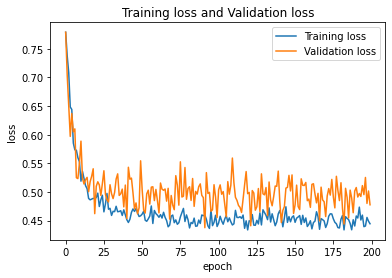

In [78]:
plot_result(train_losses,val_losses)

In [79]:
torch.save(model_1.state_dict(), '/content/gdrive/MyDrive/Year3/Indiv/CNN-1-2.pt')

In [80]:
model = Net().to(device)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/Year3/Indiv/CNN-1-2.pt'))

<All keys matched successfully>

In [81]:
# prediction for training set
with torch.no_grad():
  if (torch.cuda.is_available()):
    output = model(X_train.cuda())
  else:
    output = model(X_train)
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)
print("Training accuracy: "+str(accuracy_score(y_train, predictions)))

Training accuracy: 0.8096085409252669


In [82]:
# prediction for validation set
with torch.no_grad():
  if (torch.cuda.is_available()):
    output = model(X_val.cuda())
  else:
    output = model(X_val)
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)
print("Validate accuracy: "+str(accuracy_score(y_val, predictions)))

Validate accuracy: 0.79


## Training 3 (Dataloader)

In [83]:
class XrayClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(0.2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(0.2),
            Flatten(),
            Linear(16384, 2),
        )
    def forward(self, xb):
        return self.network(xb)

In [84]:
model_1 = XrayClassification().to(device)
print(model_1)

XrayClassification(
  (network): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
    (5): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.2, inplace=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=16384, out_features=2, bias=True)
  )
)


In [85]:
# Epoch 1-200
num_epochs = 200
opt_func = torch.optim.Adam
lr = 0.000004
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model_1, train_dataloader, validate_dataloader, opt_func, 0.0000001)

Epoch [0], train_loss: 0.7784, val_loss: 0.7091, val_acc: 0.3984
Epoch 0 : Done
Epoch [1], train_loss: 0.7278, val_loss: 0.7019, val_acc: 0.4375
Epoch 1 : Done
Epoch [2], train_loss: 0.6979, val_loss: 0.6734, val_acc: 0.6172
Epoch 2 : Done
Epoch [3], train_loss: 0.6739, val_loss: 0.6496, val_acc: 0.7344
Epoch 3 : Done
Epoch [4], train_loss: 0.6242, val_loss: 0.6293, val_acc: 0.8047
Epoch 4 : Done
Epoch [5], train_loss: 0.6097, val_loss: 0.6079, val_acc: 0.8203
Epoch 5 : Done
Epoch [6], train_loss: 0.6140, val_loss: 0.5984, val_acc: 0.8125
Epoch 6 : Done
Epoch [7], train_loss: 0.5920, val_loss: 0.5783, val_acc: 0.8125
Epoch 7 : Done
Epoch [8], train_loss: 0.5605, val_loss: 0.5653, val_acc: 0.8047
Epoch 8 : Done
Epoch [9], train_loss: 0.5529, val_loss: 0.5542, val_acc: 0.8047
Epoch 9 : Done
Epoch [10], train_loss: 0.5485, val_loss: 0.5417, val_acc: 0.8125
Epoch 10 : Done
Epoch [11], train_loss: 0.5282, val_loss: 0.5340, val_acc: 0.8281
Epoch 11 : Done
Epoch [12], train_loss: 0.5504, val_

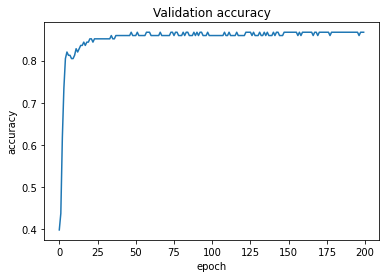

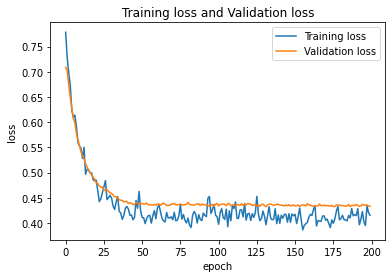

In [86]:
plot_accuracies(history)
plot_losses(history)

In [87]:
torch.save(model_1.state_dict(), '/content/gdrive/MyDrive/Year3/Indiv/CNN-1-3.pt')

In [88]:
model_1 = XrayClassification().to(device)
model_1.load_state_dict(torch.load('/content/gdrive/MyDrive/Year3/Indiv/CNN-1-3.pt'))

<All keys matched successfully>

In [89]:
train_result = evaluate(model_1, train_dataloader)
print("Training accuracy: " + str(train_result['val_acc']))

Training accuracy: 0.8454861044883728


In [90]:
val_result = evaluate(model_1, validate_dataloader)
print("Validate accuracy: " + str(val_result['val_acc']))

Validate accuracy: 0.8671875


#CNN-2

## Training 1 -> Overfit

In [13]:
class XrayClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(262144,1024), # adjust number here
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512,2)
        )
    def forward(self, xb):
        return self.network(xb)

In [14]:
model_2 = XrayClassification().to(device)
print(model_2)

XrayClassification(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=262144, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in

In [93]:
for images, labels in train_dataloader:
    print('images.shape:', images.shape)
    out = model_2(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([16, 1, 256, 256])
out.shape: torch.Size([16, 2])
out[0]: tensor([-0.0461, -0.0371], device='cuda:0', grad_fn=<SelectBackward0>)


In [15]:
num_epochs = 100
opt_func = torch.optim.Adam
lr = 0.00001
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model_2, train_dataloader, validate_dataloader, opt_func, 0.00000005)

Epoch [0], train_loss: 0.6871, val_loss: 0.6777, val_acc: 0.4531
Epoch 0 : Done
Epoch [1], train_loss: 0.5990, val_loss: 0.4936, val_acc: 0.7344
Epoch 1 : Done
Epoch [2], train_loss: 0.4686, val_loss: 0.4170, val_acc: 0.8438
Epoch 2 : Done
Epoch [3], train_loss: 0.4818, val_loss: 0.4120, val_acc: 0.8516
Epoch 3 : Done
Epoch [4], train_loss: 0.4354, val_loss: 0.3869, val_acc: 0.8516
Epoch 4 : Done
Epoch [5], train_loss: 0.4327, val_loss: 0.3848, val_acc: 0.8516
Epoch 5 : Done
Epoch [6], train_loss: 0.4186, val_loss: 0.3771, val_acc: 0.8438
Epoch 6 : Done
Epoch [7], train_loss: 0.4151, val_loss: 0.3616, val_acc: 0.8594
Epoch 7 : Done
Epoch [8], train_loss: 0.3957, val_loss: 0.3738, val_acc: 0.8516
Epoch 8 : Done
Epoch [9], train_loss: 0.3957, val_loss: 0.4021, val_acc: 0.8359
Epoch 9 : Done
Epoch [10], train_loss: 0.3783, val_loss: 0.3589, val_acc: 0.8516
Epoch 10 : Done
Epoch [11], train_loss: 0.3733, val_loss: 0.3625, val_acc: 0.8516
Epoch 11 : Done
Epoch [12], train_loss: 0.3680, val_

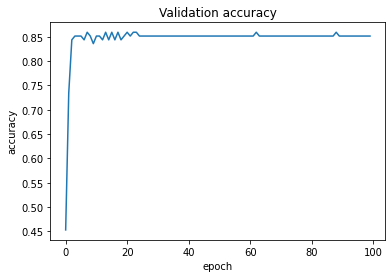

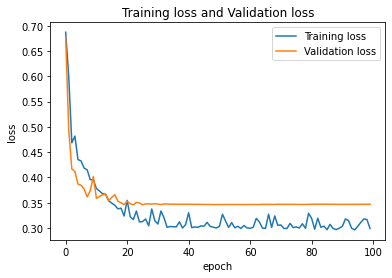

In [16]:
plot_accuracies(history)
plot_losses(history)

In [17]:
torch.save(model_2.state_dict(), '/content/gdrive/MyDrive/Year3/Indiv/CNN-2-1.pt')

In [18]:
model_2 = XrayClassification().to(device)
model_2.load_state_dict(torch.load('/content/gdrive/MyDrive/Year3/Indiv/CNN-2-1.pt'))

<All keys matched successfully>

In [19]:
train_result = evaluate(model_2, train_dataloader)
print("Training accuracy: " + str(train_result['val_acc']))

Training accuracy: 0.8784722089767456


In [20]:
val_result = evaluate(model_2, validate_dataloader)
print("Validate accuracy: " + str(val_result['val_acc']))

Validate accuracy: 0.8515625


## Training 2 (Add Dropout)

In [30]:
class XrayClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            # Add dropout ot fix overfit problem
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            # Add dropout ot fix overfit problem
            nn.Dropout(0.3),
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            # Add dropout ot fix overfit problem
            nn.Flatten(),
            nn.Linear(262144,1024), # adjust number here
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512,2)
        )
    def forward(self, xb):
        return self.network(xb)

In [31]:
model_2 = XrayClassification().to(device)
print(model_2)

XrayClassification(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.3, inplace=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.3, inplace=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Flatten(start_dim=1, end_dim=-1)
    (18): Linear(in_fea

In [32]:
num_epochs = 100
opt_func = torch.optim.Adam
lr = 0.00001
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model_2, train_dataloader, validate_dataloader, opt_func, 0.00000005)

Epoch [0], train_loss: 0.6923, val_loss: 0.6925, val_acc: 0.4297
Epoch 0 : Done
Epoch [1], train_loss: 0.6521, val_loss: 0.6201, val_acc: 0.7422
Epoch 1 : Done
Epoch [2], train_loss: 0.4973, val_loss: 0.4793, val_acc: 0.7422
Epoch 2 : Done
Epoch [3], train_loss: 0.4749, val_loss: 0.4691, val_acc: 0.8359
Epoch 3 : Done
Epoch [4], train_loss: 0.4563, val_loss: 0.4497, val_acc: 0.8438
Epoch 4 : Done
Epoch [5], train_loss: 0.4425, val_loss: 0.4470, val_acc: 0.8516
Epoch 5 : Done
Epoch [6], train_loss: 0.4350, val_loss: 0.4391, val_acc: 0.8516
Epoch 6 : Done
Epoch [7], train_loss: 0.4349, val_loss: 0.4475, val_acc: 0.8516
Epoch 7 : Done
Epoch [8], train_loss: 0.4135, val_loss: 0.4337, val_acc: 0.8359
Epoch 8 : Done
Epoch [9], train_loss: 0.4092, val_loss: 0.4101, val_acc: 0.8516
Epoch 9 : Done
Epoch [10], train_loss: 0.3983, val_loss: 0.4272, val_acc: 0.8438
Epoch 10 : Done
Epoch [11], train_loss: 0.3867, val_loss: 0.3942, val_acc: 0.8438
Epoch 11 : Done
Epoch [12], train_loss: 0.3965, val_

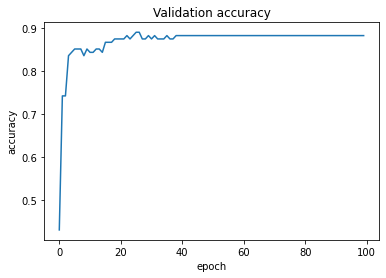

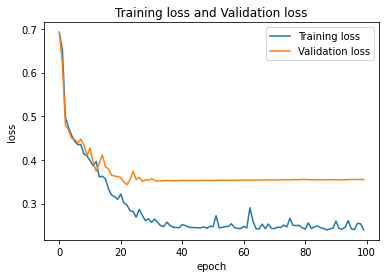

In [33]:
plot_accuracies(history)
plot_losses(history)

In [34]:
torch.save(model_2.state_dict(), '/content/gdrive/MyDrive/Year3/Indiv/CNN-2-2.pt')

In [35]:
model_2 = XrayClassification().to(device)
model_2.load_state_dict(torch.load('/content/gdrive/MyDrive/Year3/Indiv/CNN-2-2.pt'))

<All keys matched successfully>

In [36]:
train_result = evaluate(model_2, train_dataloader)
print("Training accuracy: " + str(train_result['val_acc']))

Training accuracy: 0.8888888955116272


In [37]:
val_result = evaluate(model_2, validate_dataloader)
print("Validate accuracy: " + str(val_result['val_acc']))

Validate accuracy: 0.8828125


# CNN-3 (Pretrained model): Resnet

In [16]:
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)
out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

images-size: torch.Size([16, 1, 224, 224])
out-size: torch.Size([3, 454, 1810])


In [46]:
net = models.resnet18(pretrained=True)
net = net.cuda() if torch.cuda.is_available() else net
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 16)
net.fc = net.fc.cuda() if torch.cuda.is_available() else net.fc
net.conv1 = Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
net.conv1 = net.conv1.cuda() if torch.cuda.is_available() else net.conv1

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.0001)
n_epochs = 100
val_loss,val_acc,train_loss,train_acc = train2(n_epochs,train_dataloader,validate_dataloader,net,optimizer,criterion,0.000001)

Epoch 1

Epoch [1/100], Step [0/36], Loss: 2.8146
Epoch [1/100], Step [20/36], Loss: 0.9951

train-loss: 1.1246, train-acc: 72.7758
validation loss: 0.6630, validation acc: 79.0000

Improvement-Detected, save-model
Epoch 2

Epoch [2/100], Step [0/36], Loss: 0.4450
Epoch [2/100], Step [20/36], Loss: 0.0599

train-loss: 0.7009, train-acc: 92.1708
validation loss: 0.5716, validation acc: 84.0000

Improvement-Detected, save-model
Epoch 3

Epoch [3/100], Step [0/36], Loss: 0.1561
Epoch [3/100], Step [20/36], Loss: 0.1315

train-loss: 0.5144, train-acc: 97.8648
validation loss: 0.5282, validation acc: 90.0000

Improvement-Detected, save-model
Epoch 4

Epoch [4/100], Step [0/36], Loss: 0.0259
Epoch [4/100], Step [20/36], Loss: 0.2031

train-loss: 0.4201, train-acc: 96.6192
validation loss: 0.5199, validation acc: 79.0000

Epoch 5

Epoch [5/100], Step [0/36], Loss: 0.0115
Epoch [5/100], Step [20/36], Loss: 0.0292

train-loss: 0.3433, train-acc: 98.9324
validation loss: 0.5041, validation acc: 

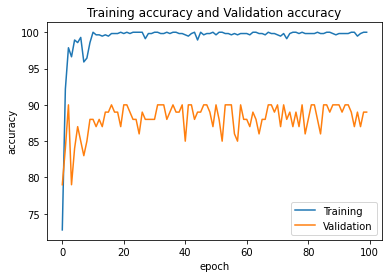

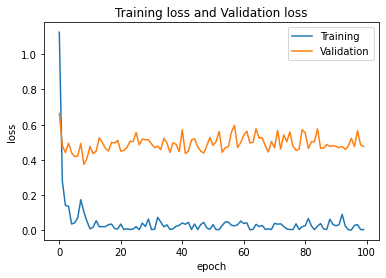

In [48]:
plot_pre_accuracy(train_acc,val_acc)
plot_pre_loss(train_loss,val_loss)

In [52]:
torch.save(net.state_dict(), '/content/gdrive/MyDrive/Year3/Indiv/CNN-3.pt')

In [53]:
model = models.resnet18(pretrained=True)
model = model.cuda() if torch.cuda.is_available() else model
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 16)
model.fc = model.fc.cuda() if torch.cuda.is_available() else model.fc
model.conv1 = Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.conv1 = model.conv1.cuda() if torch.cuda.is_available() else model.conv1
model.load_state_dict(torch.load('/content/gdrive/MyDrive/Year3/Indiv/CNN-3.pt'))

<All keys matched successfully>

In [54]:
# prediction for training set
with torch.no_grad():
  if (torch.cuda.is_available()):
    output = model(X_train.cuda())
  else:
    output = model(X_train)
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)
print("Training accuracy: "+str(accuracy_score(y_train, predictions)))

Training accuracy: 1.0


In [55]:
# prediction for validation set
with torch.no_grad():
  if (torch.cuda.is_available()):
    output = model(X_val.cuda())
  else:
    output = model(X_val)
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)
print("Validate accuracy: "+str(accuracy_score(y_val, predictions)))

Validate accuracy: 0.89
